In [34]:
from sklearn.manifold import TSNE, MDS
from keras.models import load_model
from IPython.display import SVG, Audio, display
from keras.utils.vis_utils import model_to_dot
import numpy as np
import matplotlib.pyplot as plt

In [2]:
model_path = '../models/baseline_convnet.hdf5'
downsampling = 4

In [3]:
siamese = load_model(model_path)

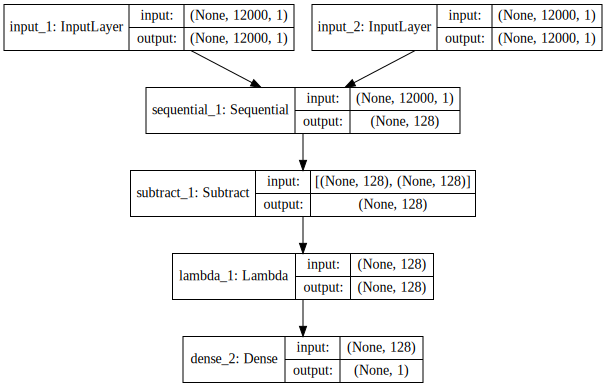

In [4]:
SVG(model_to_dot(siamese, show_shapes=True).create(prog='dot', format='svg'))

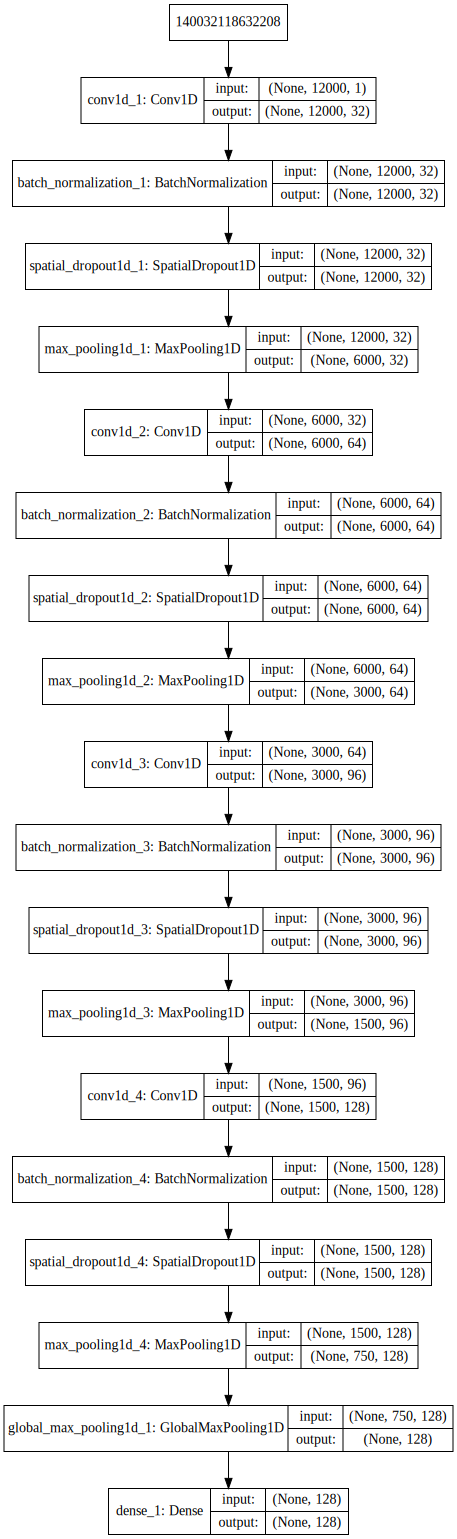

In [5]:
SVG(model_to_dot(siamese.layers[2], show_shapes=True).create(prog='dot', format='svg'))

### Extract encoder

In [6]:
from keras.models import Model
from keras.layers import Input

In [7]:
inputs = Input(shape=(12000,1))

encoded = siamese.layers[2](inputs)

In [8]:
encoder = Model(inputs=inputs, outputs=encoded)

In [9]:
encoder = siamese.layers[2]
encoder.compile(loss='mse',optimizer='adam')

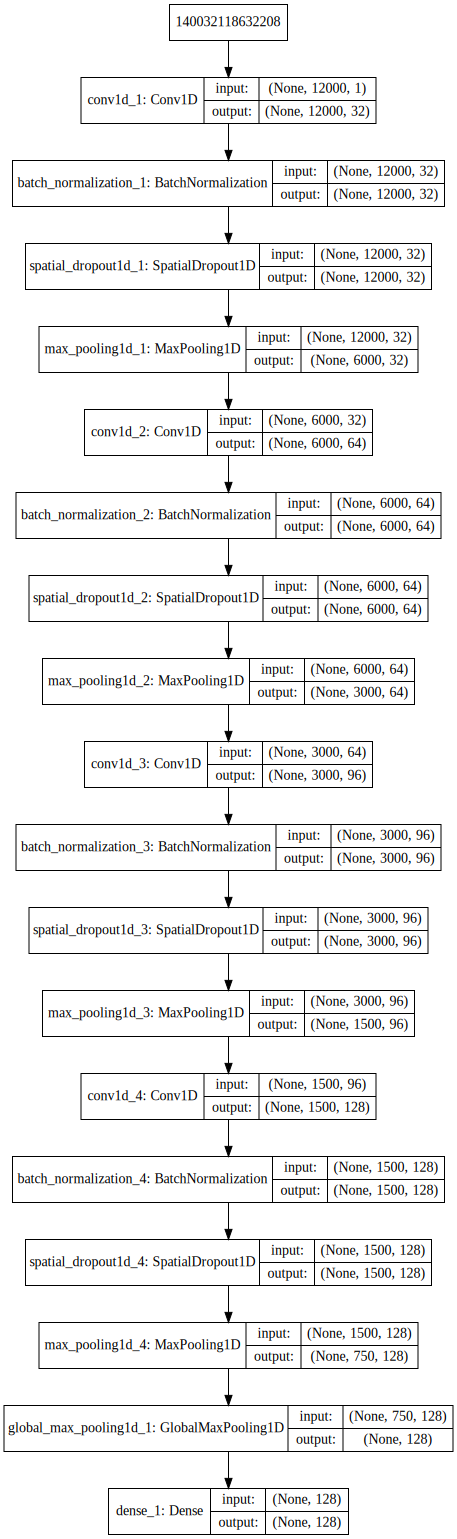

In [10]:
SVG(model_to_dot(encoder, show_shapes=True).create(prog='dot', format='svg'))

### Get data

In [22]:
import sys
sys.path.append('../')
from data import LibriSpeechDataset
from utils import whiten
from config import LIBRISPEECH_SAMPLING_RATE

In [12]:
def preprocessor(downsampling, whitening=True):
    def preprocessor_(batch):
        ([i_1, i_2], labels) = batch
        i_1 = i_1[:, ::downsampling, :]
        i_2 = i_2[:, ::downsampling, :]
        if whitening:
            i_1, i_2 = whiten(i_1), whiten(i_2)

        return [i_1, i_2], labels

    return preprocessor_


whiten_downsample = preprocessor(downsampling, whitening=True)

In [13]:
training_set = ['train-clean-100', 'train-clean-360']
train = LibriSpeechDataset(training_set, 3, stochastic=False)

Initialising LibriSpeechDataset with minimum length = 3s and subsets = ['train-clean-100', 'train-clean-360']
Finished indexing data. 129652 usable files found.


### Random samples

In [65]:
n_samples = 250

In [66]:
Z = [train[i] for i in np.random.randint(0,len(train),size=n_samples)]
X = np.stack(zip(*Z)[0])[:, :, np.newaxis]
y = np.stack(zip(*Z)[1])[:, np.newaxis]
X.shape, y.shape

((250, 48000, 1), (250, 1))

In [67]:
[X, _], _ = whiten_downsample(([X, X], []))
X.shape

(250, 12000, 1)

### Random samples from subset of speakers

In [83]:
n_speakers = 10
m_samples = 10
n_random_speakers = train.df['speaker_id'].sample(n_speakers).values

In [103]:
# Get m samples from each speaker
X, y = [], []
for i in n_random_speakers:
    Z = [train[i] for i in train.df[train.df['speaker_id']==i]['id'].sample(m_samples).values]
    X_ = np.stack(zip(*Z)[0])[:, :, np.newaxis]
    y_ = np.stack(zip(*Z)[1])[:, np.newaxis]
    [X_, _], _ = whiten_downsample(([X_, X_], []))
    
    X.append(X_)
    y.append(y_)
    
X = np.concatenate(X)
y = np.concatenate(y)

# Embed

In [104]:
embeddings = encoder.predict(X)
embeddings.shape

(100, 128)

# Dimensionality Reduction

In [105]:
def compare_samples(a, b):
    sample_a = train[a]
    sample_b = train[b]

    print 'Sample A ({}):'.format(a)
    display(Audio(data=sample_a[0],rate=LIBRISPEECH_SAMPLING_RATE))
    print 'Sample B ({}):'.format(b)
    display(Audio(data=sample_b[0],rate=LIBRISPEECH_SAMPLING_RATE))

In [106]:
tsne = TSNE(perplexity=50)

tsne_embeddings = tsne.fit_transform(embeddings)
tsne_embeddings.shape

(100, 2)

In [107]:
mds = MDS()

mds_embeddings = mds.fit_transform(embeddings)
mds_embeddings.shape

(100, 2)

In [108]:
two_d_embeddings = tsne_embeddings

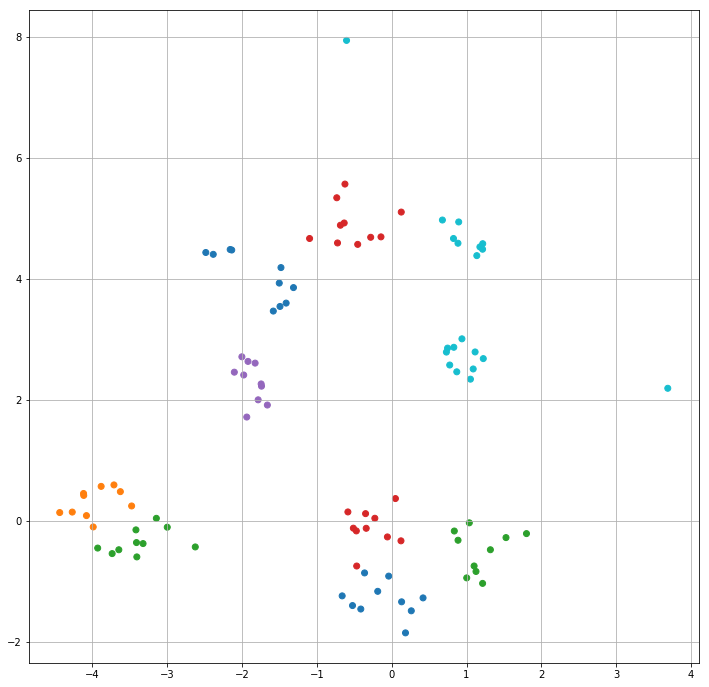

In [114]:
plt.figure(figsize=(12,12))
plt.scatter(two_d_embeddings[:, 0], two_d_embeddings[:, 1], c=y[:, 0], cmap='tab10')

# for x_, y_, idx in zip(two_d_embeddings[:, 0], two_d_embeddings[:, 1], y[:, 0]):
#     plt.text(x_, y_, idx)
    
plt.grid()
plt.show()

In [77]:
# compare_samples(4719, 5186)
# compare_samples(1849, 2012)
compare_samples(1447, 7120)

Sample A (1447):


Sample B (7120):
